# Numerical Exercises 08

Before running this notebook, you need to run the following scripts:
- `./ex08.2.sh`
- `./ex08.3.sh`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes    # zoomed up image libraries
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.integrate import quad
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style as style 
style.use('tableau-colorblind10')

# Exercise 08.2
## Variational Monte Carlo Methods (VMC)

The goal of this exercise is to minimize the energy of the following Hamiltonian, representing a single quantum particle in 1D space: 

$$
\hat H = \frac{\hat p^2}{2m} + \hat x^4 - \frac{5}{2} \hat x^2,
$$

exploiting the variational principle. As a matter of fact, the Schroedinger equation for such Hamiltonian (or more in general for a many-body hamiltonian) is not exactly solvable, and to get an estimate of the ground state energy we have to use the variational principal, which states that the variational energy $E_T$ for any wavefunction $\psi_T$ will always be higher than the ground state energy:

$$
E_T = \frac{\langle \psi_T | \hat H | \psi_T \rangle}{\langle \psi_T| \psi_T \rangle} \geq E_0 = \frac{\langle \psi_0 | \hat H | \psi_0 \rangle}{\langle \psi_0| \psi_0 \rangle}.
$$

To do so, we first choose an appropriate family of eigenfunctions: our choice is

$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}},
$$

which has the same parity as the Hamiltonian potential, and $\mu$ and $\sigma$ are the variational parameters to optimize. Then the $E_{GS}$ will be approximated by: 

$$
\langle {\hat H} \rangle_T =  
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} =
\int dx p(x) E_{loc}(x).
$$

The algorithm is:

1. Choose start value for $\mu$ and $\sigma$
2. **Metropolis algorithm** to generate $x$ points distributed as $p(x)$
3. use these points to compute a **MC** integration over $E_{loc}$ with blocking method to find uncertainties; it's worth noticing that the computation of $E_{GS}$ is exact, because its uncertainty is within the statistical uncertainty of the Monte Carlo calculation. Our estimate  will be given by:

$$
\langle\hat{H}\rangle_T=\frac{1}{M} \sum_{i=1}^M E_\text{loc}(x_i),
$$

   where $M$ is the number of sampled points.

4. Tuning $\mu$ and $\sigma$, and repeat from 2., until a best estimation of $E_{GS}$ is reached

<ipython-input-2-4fbeaf84ff4f>:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<H> is minimized when mu = 0.8 , sigma = 0.62


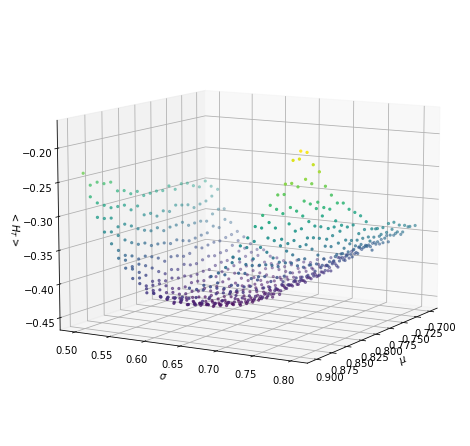

In [2]:
mu, sigma, H = np.loadtxt("build/ex08.2/variational.dat", usecols=(0,1,2), unpack = True)

fig = plt.figure(figsize = (9, 6))
ax = Axes3D(fig)
ax.scatter(mu, sigma, H, c=H, marker='.')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$<H_T>$')
ax.view_init(10, 30)

print("<H> is minimized when mu =", mu[np.argsort(H)[0]], ", sigma =", sigma[np.argsort(H)[0]])

In the following graph we compare our result with the one obtained with the following consideration: even though the Schroedinger equation has no analytical solution, we can discretize the 3D space with a lattice of $N$ points and evaluate the wavefunction in each of these points. 

Under this consideration, the Schroedinger equation can be re-written in matricial form as follow: 

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

and we can obtain the eigenvalues and eigenstates of this matrix with the calculation below.

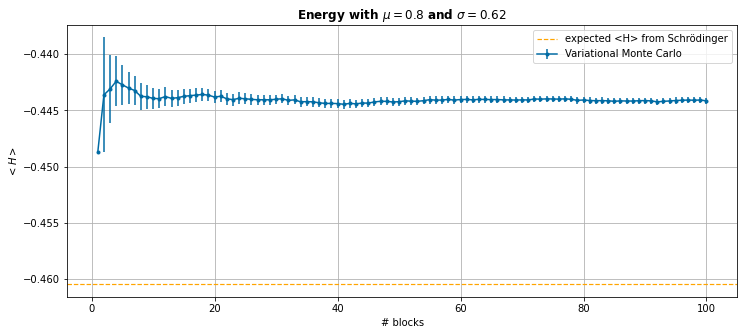

In [3]:
x, y, err = np.loadtxt('build/ex08.2/energy.dat', delimiter=" ", unpack=True)
Etrue = -0.46046587969271563

fig=plt.figure(figsize=(12, 5))
plt.title("Energy with $\mu=0.8$ and $\sigma=0.62$", weight='bold')
plt.errorbar(x, y, yerr=err, label='Variational Monte Carlo', marker='.')
plt.axhline(y=Etrue,linewidth=1.2,linestyle='--', color='orange',label='expected <H> from Schrödinger')
plt.ylabel('$<H>$')
plt.xlabel('# blocks')
plt.legend()
plt.grid(True)
plt.show()

Here we show the theoretical predictions for the probability densities of the ground state and of the first two excited states from the matricial Schroedinger's equation.

Ground state energy:  -0.46045845079911835
1st excited state energy:  0.09744706661807169
2nd excited state energy:  1.9718077373830059


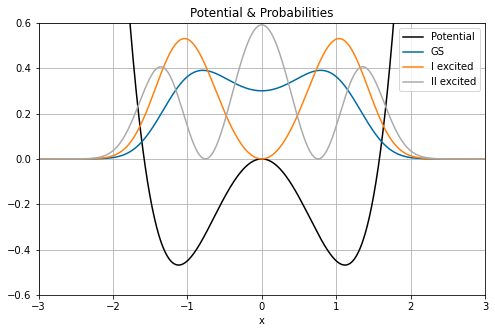

In [4]:
MU=0.79
SIGMA=0.62
def Vpot(x): return (x**2 - 2.5)*x**2

def p(x, MU, SIGMA):
    return (np.exp(-(x-MU)**2/(2*(SIGMA)**2)) + np.exp(-(x+MU)**2/(2*(SIGMA)**2)))**2
norm = quad(p, -3, 3, args=(MU,SIGMA))[0]

N = 1000 # number of iterations
hbar = 1
m = 1

x = np.linspace(-3, 3, 1000)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,ps = np.linalg.eigh(H)
ps = np.transpose(ps)
ps = ps/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(ps[0])**2, label='GS')
plt.plot(x,(ps[1])**2, label='I excited')
plt.plot(x,(ps[2])**2, label='II excited')
plt.title("Potential & Probabilities")
plt.legend()
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

Last but not least, we plot the graph of $|\Psi_T(x)|^2$, compared with the solution of the discretized Schroedinger equation and its analytical prediction (the normalized wavefunction $\Psi_T^{\mu, \sigma}$ where the optimal parameters are chose)

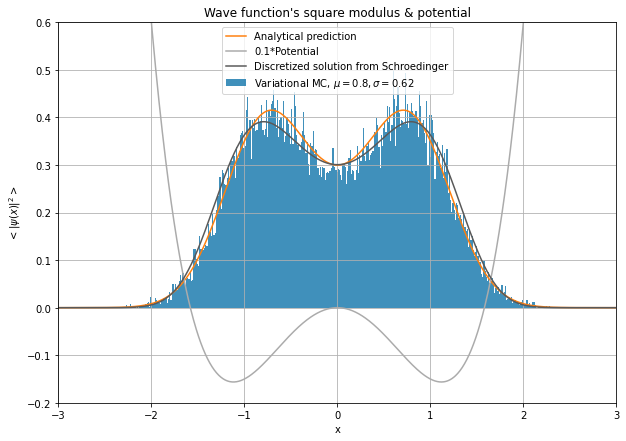

In [5]:
psi= np.loadtxt("build/ex08.2/psi_sq.dat",)
plt.figure(figsize=(10,7))
x=np.linspace(-3,3,1000)
plt.hist(psi, 400, density=True, alpha=0.75, label="Variational MC, $\mu=0.8, \sigma=0.62$")
#plt.plot(x_lin,psi_teo[0]**2, label="Analytic")
plt.plot(x,p(x, MU, SIGMA)/norm, label="Analytical prediction")
plt.plot(x, 0.1*Vpot(x), label='0.1*Potential')
plt.plot(x, ps[0]**2, label='Discretized solution from Schroedinger')
plt.legend()
plt.ylim(-0.2, 0.6)
plt.xlim(-3,3)
plt.grid(True)
plt.xlabel("x")
plt.title("Wave function's square modulus & potential")
plt.ylabel("$< |\psi(x)|^2 >$" )

plt.show()

# Exercise 08.3
## PIGS & PIMC algorithms

The goal of this exercise is to study the same 1D quantum system as before using a path integral approach. In fact, thanks to Feyman's idea to map a quantum system to a classical model of special interacting ring poymers, we have a strong computational tool to estimate the GS of a system a $T=0$ (PIGS Algorithm) and a $T>0$ (PIMC Algorithm).

### Brief note on the theoretical assumptions
In the path integral approach, with the formalism of the Green's functions, we have that

$$
\psi(\vec r, t) = \int d^3r' \langle \vec r | e^{-it \hat H /\hbar}| \vec r' \rangle \langle \vec r'| \psi(0) \rangle = \int d^3 r' G(\vec r, \vec r', t) \psi(\vec r', 0).
$$

Performing the Wick's rotation $t \to \tau = i t / \hbar$, we can write the wavefunction in terms of the imaginary time $\tau$; what's more, the effect of this rotation for high $\tau$ is to suppress the contribution of the excited eigenstates:

$$
| \psi(\tau) \rangle = e^{-\tau \hat H} |\psi(0) \rangle 
= e^{-\tau \hat H} \sum_n c_n |\psi_n \rangle = \sum_n c_n e^{-\tau  E_n} |\psi_n \rangle \sim_{\tau >> 1} e^{-\tau E_0} |\psi_0 \rangle.
$$

Then we can approximate the Green function $G(\vec r, \vec r', \tau)$, which is a density matrix, using the Lie-Trotter decomposition and the primitive approximation. So combining the Wick rotation, the primitive approximation for the propagator, and dividing the time interval in $M$ timeslices, for big enough $M$ we manage to map the quantum system to a classical system of ring polymers, which we can sample with a Metropolis algorithm.

At finite temperature the idea is more or less the same, but the initial state will be described by a statistical mixture, so that the average of the  observable $\hat O$ will be:

$$
\langle \hat O \rangle = Tr(\hat \rho \hat O) = \frac{\int d^3 r \rho(\vec r, \vec r, \beta) O(\vec r)}{Tr(\hat \rho)}
$$

In this case the Trotter decomposition is used on the density matrix $\rho(\vec r, \vec r, \beta)= \langle \vec r|e^{-\beta \hat H}|\vec r\rangle$, and, using high $M$ following the primitive approximation in: $e^{-\tau \hat H} = (e^{-\tau/M \hat H})^M$, we recover the thermal expectation value that can be computed with MC integration.

## Results

In the next plot we show the results for the ground state energy obtained through the PIGS algorithm, both with a constant trial wavefunction and a variational trial wavefunction (in particular the optimal wavefunction found in the previous exercise). The results are compatible with the expected values, both the one from the discretized Schroedinger method and the one obtained via variational method. 

We also observe how the constant trial needs more time to stabilize and reach the desired energy values; this is because the wavefunction is far from the correct one; instead the variational trial wavefunction is already close the correct one, and thus needs less time to reach stable values.

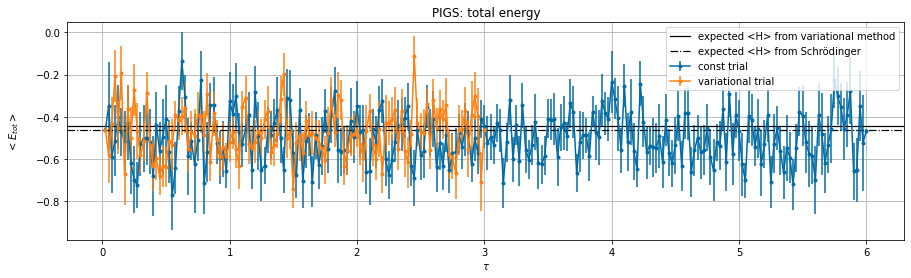

In [6]:
PIGS=[0 for i in range(4)]; obs=['potential','kinetic']; tau=['const_t6','var_t3']; tt=(6,3); tslice=(240,120)
for i in range(2):
    for j in range(2):
        PIGS[2*i+j]=np.genfromtxt('build/ex08.3/results/'+obs[i]+'.'+tau[j]+'.dat',names='time,res,err')
        
trial_type=("const trial","variational trial")
ene,err=[0,0],[0,0]
for i in range(2):
    ene[i]=PIGS[i]['res']+PIGS[i+2]['res']
    err[i]=np.sqrt(PIGS[i]['err']**2+PIGS[i+2]['err']**2)
    
fig,ax=plt.subplots(figsize=(15,4))
for i in range(2): plt.errorbar((PIGS[i]['time']+1)/tslice[i]*tt[i],ene[i],yerr=err[i],marker='.',label=trial_type[i])
plt.axhline(y=-0.444175,color='k',linewidth=1.2,label='expected <H> from variational method')
plt.axhline(y=E[0],color='k',linewidth=1.2,linestyle='-.',label='expected <H> from Schrödinger')
plt.legend(loc='best')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$<E_{tot}>$',labelpad=15)
plt.grid(True)
plt.title("PIGS: total energy")
plt.show()

In the next graph we show the potential energy results using both trials. In the both of them we can see a sort of simmetry: this is due to the periodic boundary conditions of the algorithm. But in the central region the values of the potential energy are quiet constant, and we can consider this region as an appropriate time interval for the sampling of the ground state wavefunction.

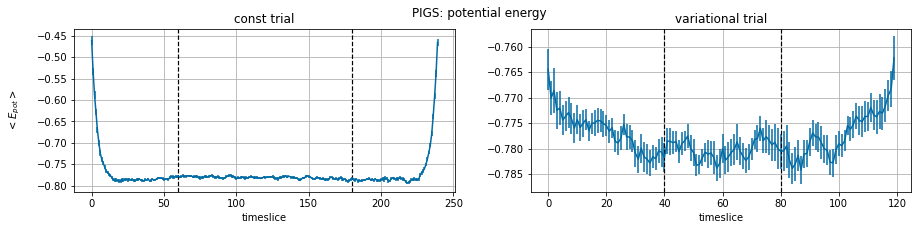

In [7]:
def img_evol(plot,howMany,xline,color):
    fig,ax=plt.subplots(figsize=(15,3))
    for i in range(2):
        plt.subplot(1,2,i+1)
        for j in range(howMany):
            plt.errorbar(plot[i+2*j]['time'],plot[i+2*j]['res'],yerr=plot[i+2*j]['err'])
            for k in [2*i+4*j,2*i+4*j+1]: plt.axvline(x=xline[k],color=color[j],linewidth=1.2,linestyle='--')
        plt.xlabel(r'timeslice')
        if i==0: plt.ylabel('$<E_{pot}>$',labelpad=15)
        plt.grid(True)
        plt.title(trial_type[i])
    plt.suptitle("PIGS: potential energy")
    plt.show()
    
img_evol(PIGS,1,(60,180,40,80),'k')

The next two graphs show the sampling produced with different time of evelution $\tau$. It's important to notice that, when selecting the timeslices to be used for the sampling of the wavefunction, we considered times for which the potential energy is stable; these choices led to good results. In particular they are:

- for $\tau = 1$ we select the timeslices in $[15, 25]$;
- for $\tau = 2$ we select the timeslices in $[30, 50]$;
- for $\tau = 3$ we select the timeslices in $[40, 80]$;
- for $\tau = 5$ we select the timeslices in $[50, 150]$.

The samplings are in accordance to the matrix equation theoretical result. The final plots represent the probability density of finding the particle at a certain $x$ point, when in the ground state energy level.

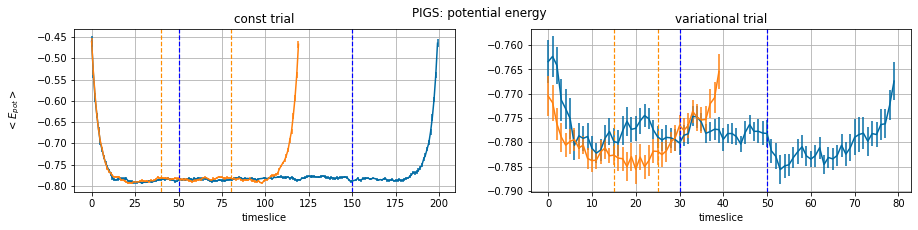

In [8]:
newPIGS=[0 for i in range(4)]
psiT=['const','var']*2
tau=['5','2','3','1']
for i in range(len(newPIGS)):
        newPIGS[i]=np.genfromtxt('build/ex08.3/results/potential.'+psiT[i]+'_t'+tau[i]+'.dat',names='time,res,err')
        
img_evol(newPIGS,2,(50,150,30,50,40,80,15,25),('b','darkorange'))

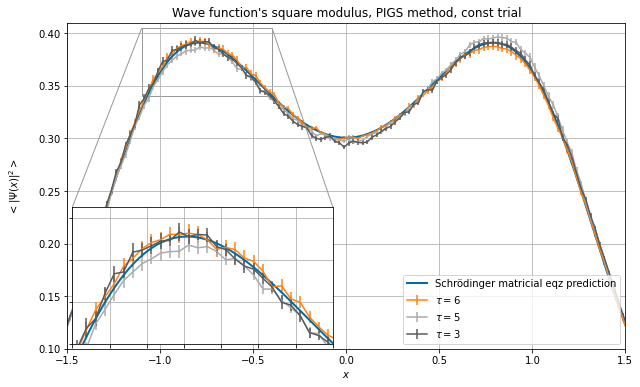

In [9]:
def wave_function(irg,plot,mark,lab,ifpot,xrg,yrg,title):
    plt.plot(x,(ps[0])**2,linewidth=2,label='Schrödinger matricial eqz prediction')
    for i in irg: plt.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i],label=lab[i])
    if ifpot: plt.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black", label="0.1*Potential")
    plt.legend(loc=4)
    plt.xlabel('$x$')
    plt.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
    plt.xlim(xrg)
    plt.ylim(yrg)
    plt.grid(True)
    plt.title(title)

def zoom(factor,irg,plot,mark,ifpot,xrg,yrg):
    axins=zoomed_inset_axes(ax,factor,loc=3)   # zoomed part, zoom and position
    axins.plot(x,(ps[0])**2,linewidth=2)
    for i in irg: plt.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i])
    if ifpot: axins.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black")
    axins.set_xlim(xrg)
    axins.set_ylim(yrg)
    plt.grid(True)
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=1,fc='none',ec='0.6')

psiPIGS=[0 for i in range(7)]
psiT=['const' for i in range(3)]+['var' for i in range(4)]
tau=['6','5','3','3','2','1','05']
for i in range(len(psiPIGS)):
    psiPIGS[i]=np.genfromtxt('build/ex08.3/results/probability.'+psiT[i]+'_t'+tau[i]+'.dat',names='nbin,res,err')

lab=('const trial','variational trial')

tau=['6','5','3','3','2','1','05']
fig,ax=plt.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3)
wave_function(irg,psiPIGS,mark,[r'$\tau='+tau[i]+'$' for i in irg],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, const trial")
zoom(2,range(3),psiPIGS,mark,False,(-1.1,-0.4),(0.34,0.405))
plt.show()

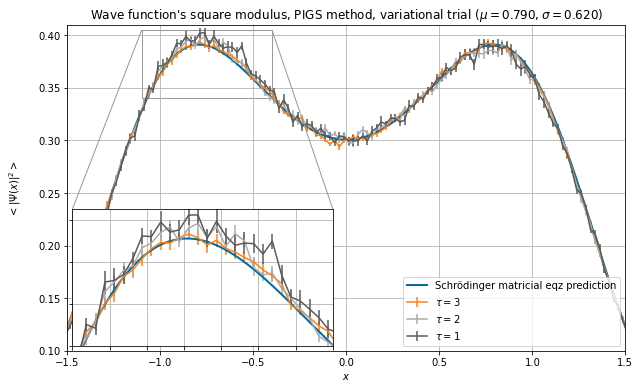

In [10]:
tau=['6','5','3','3','2','1','05']
fig,ax=plt.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3,6)
wave_function(irg,psiPIGS,mark*2,[r'$\tau='+tau[i]+'$' for i in range(6)],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, variational trial ($\mu="+format(MU,'.3f')+",\sigma="+format(SIGMA,'.3f')+"$)")
zoom(2,irg,psiPIGS,mark*2,False,(-1.1,-0.4),(0.34,0.405))
plt.show()

Last but not least, we estimate what happens at finite temperature with the PIMC temperature. 
We can see from the graph that has temperature increases the function becomes smoother: it is evolving to a state in which each position is equiprobable. This does not happen at low $T$, where the probability of occupying the central region decreseas as $T$ increases.

A possible explanation for this behavior is the fact that by increasing the temperature just a little bit we are giving enough energy to "fall" into one of the two symmetriacal low energy regions but not enough energy to escape from it.

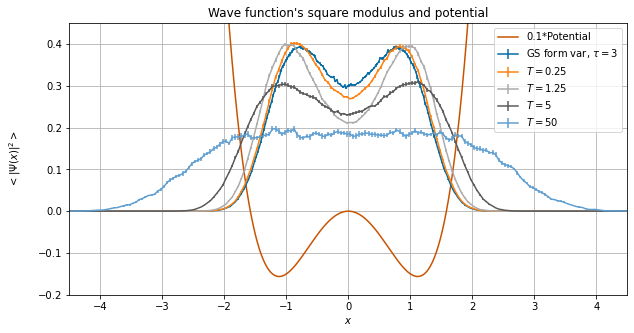

In [11]:
psiPIMC_0_25=np.genfromtxt('build/ex08.3/results/probability.T0_25.dat',names='nbin,res,err')
psiPIMC_1_25=np.genfromtxt('build/ex08.3/results/probability.T1_25.dat',names='nbin,res,err')
psiPIMC_5=np.genfromtxt('build/ex08.3/results/probability.T5.dat',names='nbin,res,err')
psiPIMC_50=np.genfromtxt('build/ex08.3/results/probability.T50.dat',names='nbin,res,err')
PIMC=(psiPIMC_0_25,psiPIMC_1_25,psiPIMC_5,psiPIMC_50)
x = np.linspace(-3, 3, 1000)

fig,ax=plt.subplots(figsize=(10,5)); label=('0.25','1.25','5','50')
plt.errorbar(psiPIGS[3]['nbin'],psiPIGS[3]['res'],yerr=psiPIGS[3]['err'],label=r'GS form var, $\tau=3$')
for i in range(4): plt.errorbar(PIMC[i]['nbin'],PIMC[i]['res'],yerr=PIMC[i]['err'],label=r'$T='+label[i]+'$')
plt.plot(x, 0.1*Vpot(x), label='0.1*Potential')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
plt.xlim(-4.5,4.5)
plt.ylim(-0.2,0.45)
plt.grid(True)
plt.title("Wave function's square modulus and potential")
plt.show()